# Applying a Gradient Free Sampling Based Approach For Training Deep Spiking Neural Networks

## Computational Neuroscience basics

The following excerpts are from the "Computational Neuroscience" coursera course from the University of Washington by Rajesh P.N.Rao and Adrienne Fairhall.

### Receptive Fields

#### Descriptive Model

This model describes *what* a receptive field is. There are two main take-aways:
- Encoding - how a neuron reacts to stimuli
- Decoding - inferring information from neurons

A receptive field can take many forms in order to react to a wide range of different stimuli. Here are two receptive fields used in our sense of sight:

![image](images/ReceptiveField1.PNG "Receptive Field")

This is a receptive field found in the retina. It responds to a bright spot surrounded by darkness

![image](images/ReceptiveField2.PNG "Receptive Field")

This is a receptive field found in the primary visual cortext (which recieves an image from the retina). It responds to a bright strip surrounded by darkness.

#### Mechanistic Model

This model describes *how* a receptive field works. We simulate the behaviour of either single neurons or networks of many neurons.

![image](images/ReceptiveField3.PNG "Receptive Field")

The above image shows how the receptive field in the visual cortex are formed using the retinas receptive field as building blocks. It is evident that multiple receptive fields from the latter feed into a single receptive field of the former.

#### interpretive Model

This model describes *why* a receptive field works the way it does, and the computational principles underlying these operations. 

![image](images/ReceptiveField4.PNG "Receptive Field")

Above we have multiple examples of receptive fields that may be present in the visual cortex. From them we now want an explanation as to why they are the way they are and what computational advantages there are to having such fields.

We can consider an image $ I $ being reconstructed into $ \hat{I} $ with a linear sum of receptive fields: 

$$ \hat{I} = \sum_iRF_ir_i $$

Where $ r_i $ are the neural respones. The main idea is to find the minimal $ RF_i $ that minimise the squared pixelwise errors between $ I $ and $ \hat{i} $ while being as independent as possible. This is the so called 'efficient coding algorithm'. Running this algortithm on randomised sets of $ RF_i $ surprisingly yield the same receptive fields found in the human body.

### Electrical Properties of Neurons

![image](images/IdealNeuron.PNG "Neuron")
image by Eric Chudler, UW

Above is an image of an ideal neuron showing its basic structure and it's input and output. Multiple input from other neurons' axons enter the dentrites, and in in the case of a spike, a signal travels down the axon into the dentrites of any other neurons' Dendrites via synapses.

![image](images/IonicChannel.PNG "Ion Channel")

Spikes are generated due to the control of ionic channels, that allow or block certain ions to enter or exit the neuron. This in turn causes changes in the voltage potential of the cell.

![image](images/Spike.PNG "Spike")
image by Eric Chudler, UW

Above is an illustration of how the changes in the neurons ionic makeup create the signature spike shape.

![image](images/ElectricalSynapse.PNG "Eletrical Synapse")
![image](images/ChemicalSynapse.PNG "Chemical Synapse")

These are the two types of synapse that the brain uses to transmits signals between neurons, the left being an electrical synapse (That uses a gap junction to form a potential difference between the two neurons) and the right being a chemical one (That uses neurotransmitters to open ionic channels in the postsynaptic neuron). 

These synapses are responsible for memory and learning in the brain, using something named *Hebbian Plasticity*. If a neuron repeatedly takes part in the firing of another neuron, then the synapse between then is strengthened. This means that spikes occur more readily in the latter neuron when the former one fires in the future (i.e there will be higher excitory postsynaptic potential (EPSP)). This is called *long Term Potentiation* (LTP). The opposite is also true, and this phenomena is called *Long Term Depression* (LTD).

LTP and LTD are dependent on the relative timings of the presynaptic and postsynaptic neurons. If the input spike is before the output spike then there is LTP, and in the converse case there is LTD.

![image](images/LTP.PNG "LTP")
![image](images/LTD.PNG "LTD")

A common equation used to represent Spike-Dependent Timing Plasticity (SDTP) is given by: 

$$\Delta w = \sum_{t_{pre}} \sum_{t_{post}} W(t_{post}-t_{pre})$$

$$W(\Delta t) = \begin{cases}
A_{pre} e^{-\Delta t/\tau_{pre}} & \Delta t>0 \\
A_{post} e^{\Delta t/\tau_{post}} & \Delta t<0
\end{cases}$$

Essentially we are summing a function of the difference between pre- and post- synaptic spikes to get the synaptic weight change. This is highly innefecient to run over all synapses and so we have equivalent formulations given by the Brian code below

C:\Users\tejas\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


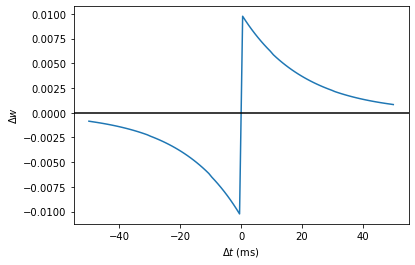

In [1]:
from brian2 import *
%matplotlib inline

start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');

### Neural Encoding

This is trying to describe how a stimulus casues a pattern of respone, i.e $ p(response|stimulus) $.

Neural representation of information is when we plot the neural response (e.g average firing rate) against a certain stimulus parameter (e.g sound volume, frequency etc).

#### Basic Encoding Models

we have basic encoding models that would give us the average firing rate given a stimulus (i.e $ p(response|stimulus) \rightarrow r(t) $

##### Linear Response

The most basic theory we could put forward is that the response at each time is linearly dependent on the stimulus at any given moment.

$$ r(t) = \phi s(t) \; or \; \phi s(t-\tau) $$

But this cannot be the whole picture. In reality we need to take into account previous inputs as well the current one to calculate the response of a neuron. 

$$ r(t) = \sum_{k=0}^ns_{t-k}f_k \: or \: r(t) = \int^t_{-\infty}s(t-\tau)f(\tau)d\tau $$

where we have the current stimulus $ s $ as well as the stimulus $ k $ steps into the past weighted by $ f $, which is a function of $ k $. We notice here that when formed into an integral it is very similar to convolution for a Linear Time Invariant (LTI) filter (i.e $ r(t) = s*f $). This system is known as a *temporal filter* as it is dependent on relative time. You can also have spatial filters:

$$ r(x, y) = \sum_{x'=0,y'=-n}^ns_{x-x',y-y'}f_{x',y'} \: or \: \int_{-\infty}^\infty s(x-x',y-y')f(x',y')dx'dy' $$

Where the response at a certain point is effected by the response of its surrounding points on a 2-D plane.

To complete our conceptualisation we must take into account that firing rates cannot be negative, and so we must introduce a non-linear function that achieves this. We can write this full equation as:

$$ r(t) = g(\int^t_{-\infty}s(t-\tau)f(\tau)d\tau) $$

Where $ g $ is a non-linear function

In general you can think of a stimulus going through miltiple blocks, that each have thier own function. We can model these blocks like so:

![image](images/EncodingModel.png "Receptive Field")

We have the input stimulus going into a feature (i.e our linear filter), and then into an I/O function (i.e out non-linear function), which then outputs the firing rate of that specific neuron.

#### Selecting Features

When we are plotting the response given the stimulus, we want to further generalise it for many stimuli to see what the response is for all inputs. Something that is commonly used for this stimulus is gaussian white noise. This noise makes calculations easy since it is gaussian in all dimensions, and is also equally represnted in all frequencies equally.

In order to plot this we discretise the stimuli into n timepoints, and record it as an n-dimentional vector which can be plotted on an n-dimentional plot.



Shown below is an example of how a Spike-Triggered Average (STA) would be computed from a set of data. It shows that this particular neuron responds to a sharp increase icrease in the stimulus parameter, that shortly thereafter declines to its resting value.

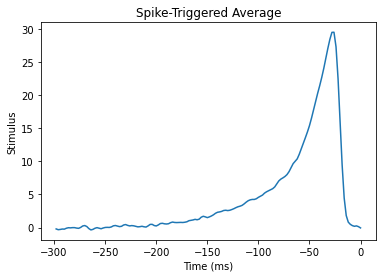

In [4]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import sys

def compute_sta(stim, rho, num_timesteps):
    """Compute the spike-triggered average from a stimulus and spike-train.
    
    Args:
        stim: stimulus time-series
        rho: spike-train time-series
        num_timesteps: how many timesteps to use in STA
        
    Returns:
        spike-triggered average for specified number of timesteps before spike"""
    
    sta = np.zeros((num_timesteps,))

    # This command finds the indices of all of the spikes that occur
    # after 300 ms into the recording.
    spike_times = rho[num_timesteps:].nonzero()[0] + num_timesteps
    
    # Fill in this value. Note that you should not count spikes that occur
    # before 300 ms into the recording.
    num_spikes = len(spike_times)
    
    # Compute the spike-triggered average of the spikes found.
    # To do this, compute the average of all of the vectors
    # starting 300 ms (exclusive) before a spike and ending at the time of
    # the event (inclusive). Each of these vectors defines a list of
    # samples that is contained within a window of 300 ms before each
    # spike. The average of these vectors should be completed in an
    # element-wise manner.
    # 
    # Your code goes here.
    
    for i in spike_times:
        for j in range(num_timesteps):
            sta[j] = sta[j] + stim[i-num_timesteps+j]

    sta = sta/num_spikes
    
    return sta

sys.path.append(os.path.realpath('datasets/c1p8.pickle'))
FILENAME = 'datasets/c1p8.pickle'

with open(FILENAME, 'rb') as f:
    data = pickle.load(f)
    
stim = data['stim']
rho = data['rho']
    

# Fill in these values
# number in ms
sampling_period = 2
num_timesteps = 150

sta = compute_sta(stim, rho, num_timesteps)

time = (np.arange(-num_timesteps, 0) + 1) * sampling_period

plt.plot(time, sta)
plt.xlabel('Time (ms)')
plt.ylabel('Stimulus')
plt.title('Spike-Triggered Average')

plt.show()

### Neural Decoding

This is trying to describe what a response tells us about the stimulus that caused it, i.e $ p(stimulus|response) $.